In [133]:
# IMPORT PACKAGES
import os, datetime
import IPython
import IPython.display
import sklearn, pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [134]:
# DATA LOADING
csv_path = "dataset/ecommerceDataset.csv"
MODEL_PATH = os.path.join(os.getcwd(),'saved_models','model.pkl')
df = pd.read_csv(csv_path) # file does not have column names
print(df.info())
print(df.head(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50424 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [135]:
# Add column names for data 
column_names = ['category','text']
df = pd.read_csv(csv_path,names=column_names)
df.columns
print(df.head(1))

    category                                               text
0  Household  Paper Plane Design Framed Wall Hanging Motivat...


In [136]:
# DATA INSPECTION
print("Shape of the data: ",df.shape)
print("Data description: \n",df.describe().transpose())
print("NA value: \n",df.isna().sum())
print("Duplicated values: ",df.duplicated().sum())
print("Categories: \n",df['category'].value_counts())

Shape of the data:  (50425, 2)
Data description: 
           count unique                                                top  \
category  50425      4                                          Household   
text      50424  27802  Think & Grow Rich About the Author NAPOLEON HI...   

           freq  
category  19313  
text         30  
NA value: 
 category    0
text        1
dtype: int64
Duplicated values:  22622
Categories: 
 category
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64


In [137]:
# Replace NA values with 'missing' 
df['text'] = df['text'].fillna('missing')
print("NA value: \n",df.isna().sum())

NA value: 
 category    0
text        0
dtype: int64


In [138]:
# DATA PREPROCESSING
# Since the label is in form of text, we need to convert it to number
# (A) Separate the feature and label
feature = df['text'].values # it's only 1 column, no need to be series
label = df['category'].values
# (B) Perform label encoding to the category column
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoded = label_encoder.fit_transform(label) # .fit means that it's already trains
label_encoded[:5]

array([3, 3, 3, 3, 3])

In [139]:
# Use the label encoder to do inverse transform
sample_categories = label_encoder.inverse_transform([0,1,2,3])
print(sample_categories)

['Books' 'Clothing & Accessories' 'Electronics' 'Household']


In [140]:
# PERFORM TRAIN-VAL-TEST SPLIT
seed = 42
x_train, x_split, y_train, y_split = sklearn.model_selection.train_test_split(feature, label_encoded, train_size=0.7, random_state=seed)
x_val, x_test, y_val, y_test = sklearn.model_selection.train_test_split(x_split, y_split, train_size=0.5, random_state=seed)

In [141]:
# NLP
# (A) Tokenization
tokenizer = keras.layers.TextVectorization(max_tokens=5000, output_sequence_length=200)
tokenizer.adapt(x_train)

In [142]:
# Test how the tokenizer works (no 1, 2)
sample_tokens = tokenizer(x_train[:2]) # the first 2 data
print(x_train[:2])
print(sample_tokens)

['UPSC New Syllabus & Tips to Crack IAS Preliminary and Mains Exam with Rapid GK 2019 ebook About the Author Disha Experts is a team of most renowned and prolific content writers pioneering in School and Test Prep segments (Competitive Exams and Government Vacancies). It consists of more than 30 experts comprising of IITians, PhDs, B-Techs, PGs, etc. working full-time with decades of experience in various academic and competitive exam verticals. Disha Experts has emerged as a think tank in the School and Test Prep segments providing the most updated (latest pattern and syllabus-wise) to-the-point student friendly (relevant and easy-to-understand presentation) content such that the aspirants can give their best.'
 'SOUMIK ELECTRICALS 5-inch Subwoofer with Maximum 4 ohm(100 W) Thisb product is from the brand SOUMIK ELECTRICALS it presents a 5 Inch subwoofer with maximum 4 ohm and comes with 100W. Use in your home theatre.']
tf.Tensor(
[[3678   57 2388 1996    5 3505 3558 4572    3 3854  

In [143]:
# (B) Embedding
embedding = keras.layers.Embedding(5000,64)

In [144]:
# MODEL DEVELOPMENT
model = keras.Sequential()
# (A) NLP layers
model.add(tokenizer)
model.add(embedding)
# (B) RNN
model.add(keras.layers.Bidirectional(keras.layers.LSTM(32,return_sequences=False)))
model.add(keras.layers.Dense(len(df['category'].unique()),activation='softmax'))

In [ ]:
# MODEL COMPILE
# f1_metric = keras.metrics.F1Score(average='macro')
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [146]:
# MODEL TRAINING
logpath = "tensorboard/ecommerce/" + datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
tb = keras.callbacks.TensorBoard(logpath)
es = keras.callbacks.EarlyStopping(patience=2, verbose=3)
history = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=10,batch_size=32,callbacks=[tb,es])

Epoch 1/10
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 133s 113ms/step - accuracy: 0.7998 - loss: 0.5281 - val_accuracy: 0.9602 - val_loss: 0.1433
Epoch 2/10
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 124s 112ms/step - accuracy: 0.9726 - loss: 0.1033 - val_accuracy: 0.9669 - val_loss: 0.1290
Epoch 3/10
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 134s 121ms/step - accuracy: 0.9828 - loss: 0.0669 - val_accuracy: 0.9695 - val_loss: 0.1179
Epoch 4/10
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 124s 113ms/step - accuracy: 0.9880 - loss: 0.0457 - val_accuracy: 0.9692 - val_loss: 0.1254
Epoch 5/10
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 126s 114ms/step - accuracy: 0.9904 - loss: 0.0351 - val_accuracy: 0.9613 - val_loss: 0.1517
Epoch 5: early stopping


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_5            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 200, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,035,278 (3.95 MB)

 Trainable params: 345,092 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 690,186 (2.63 MB)

None


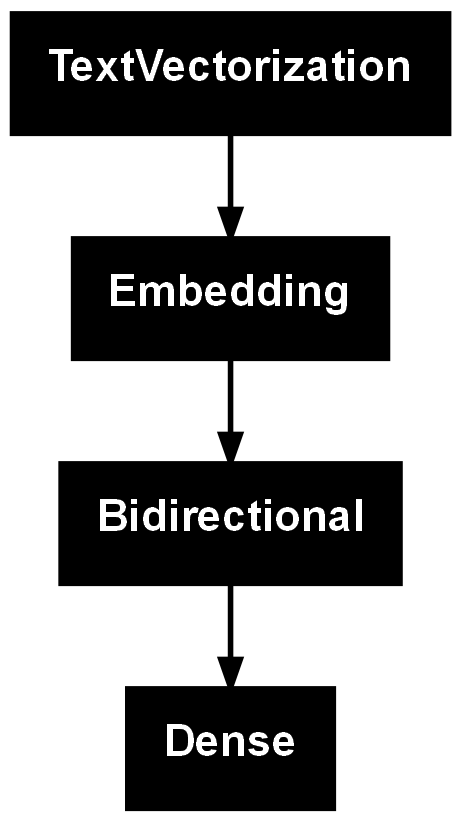

In [156]:
print(model.summary()) # to see model's architecture
keras.utils.plot_model(model)

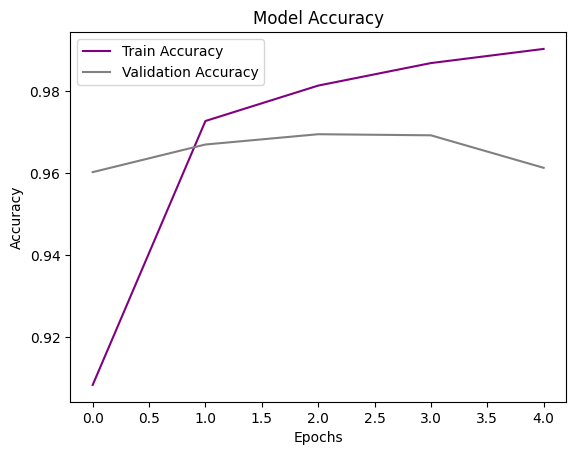

In [ ]:
# Plot Accuracy Graph 
plt.plot(history.history['accuracy'], label='Train Accuracy', color='purple')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='grey')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()  
plt.show()

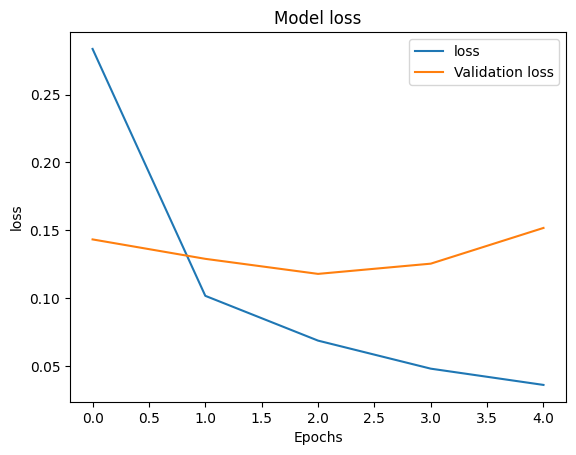

In [166]:
# Plot Loss Graph
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [167]:
# Further evaluate with test data
evaluation = model.evaluate(x_test,y_test)
print(evaluation)
# from the evaluation, we have 96.3% accuracy which is ok 

237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9658 - loss: 0.1416
[0.15397578477859497, 0.9625859260559082]


In [168]:
y_true = np.array([[1,1,1],
                  [1,0,0],
                  [1,1,0]], np.int32)
print(y_true.shape)

(3, 3)


In [169]:
from sklearn.metrics import classification_report
prediction = model.predict(x_test)
prediction_index = np.argmax(prediction,axis=1)
model_report = classification_report(y_test,prediction_index)
print(model_report)

237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1765
           1       0.98      0.98      0.98      1346
           2       0.96      0.96      0.96      1509
           3       0.94      0.98      0.96      2944

    accuracy                           0.96      7564
   macro avg       0.97      0.96      0.96      7564
weighted avg       0.96      0.96      0.96      7564



In [170]:
# # F1 Score
# predictions = model.predict(x_test)
# y_pred = np.argmax(predictions,axis=1)
# y_pred = y_pred.reshape(1,-1)
# print(y_pred.shape)

# y_test = y_test.reshape(1,-1)
# print(y_test.shape)

# metric = keras.metrics.F1Score(threshold=0.5)
# metric.update_state(y_test,y_pred)
# result = metric.result()
# print(result)

In [171]:
# USE THE MODEL FOR INFERENCE
predictions = model.predict(x_test[:3])
class_predictions = label_encoder.inverse_transform(np.argmax(predictions,axis=1))
print(x_test[:3])
print(class_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
['72 Music Scales: For Composers & Improvising Musicians '
 'Anchor Fly with Me Stitch Kit A range of over 300 d-i-y kits with easy to make embroidery designs on canvas. Anchor stitch kits contain everything you need to help you make your own special embroidery creation. Happy crafting.'
 "Wall1ders Atulya Arts 3D Hexagon Acrylic Stickers with 20 Butterfly Wall Stickers (Silver) -Pack of 14 First Time in India!!! An INDIAN COMPANY named “Atulya Arts” presenting new trend of wall decoration in 3D acrylic, made using imported cast acrylic with computerized laser cutting method. Design you wall with your own creativity Buy from trusted name only!!! 'Atulya Arts' products are of premium quality and use only high standard material. Our products are quality controlled and pre stocked. Atulya Arts - Presenting high quality 3D Mirror or 3D acrylic sticker, Search Atulya Arts - acrylic, Atulya Arts - acrylic sticker that is affixed to a wall or other smoot

In [172]:
# SAVE THE NECESSARY COMPONENTS
# (A) Label encoder
with open("saved_models/ecommerce_encoder.pkl","wb") as f:
    pickle.dump(label_encoder,f)

In [173]:
# (B) Model
keras.models.save_model(model,"saved_models/ecommerce_analysis.h5")

In [174]:
# (C) Tokenizer 
with open('saved_models/tokenizer.json','wb') as f:
    pickle.dump(tokenizer,f)